In [1]:
import sys,os
os.chdir('../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from functions import nufit_params_nsi, nufit_params_nsi_IO
from PINGU.event_processing import return_precomputed_nsi, to_hist
from PINGU.event_processing import get_deltachi as deltachi_PINGU
from DC.event_processing import get_param_list, list_of_params_nsi, get_best_fit
from DC.event_processing import get_deltachi as deltachi_DC
from DC.event_processing import get_marginalized_array as marginalize_DC
from PINGU.event_processing import get_marginalized_array as marginalize_PINGU
from IC.event_processing import get_deltachi as deltachi_IC
from IC.event_processing import normalize_events
from scipy.stats import chi2
import pickle
from scipy.interpolate import splrep, splev, sproot
from src.plotter import save, savethesis
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
np.set_printoptions(precision=4)
df_I = pd.DataFrame()
df_D = pd.DataFrame()
df_ID = pd.DataFrame()

df_P = pd.DataFrame()
df_PD = pd.DataFrame()
df_PID = pd.DataFrame()

In [2]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
ordering = 'NO'
IO = False if ordering == 'NO' else True
worst_cases={}
normal_cases={}
best_cases={}
nsi_list = ['ett','emt','eem','eet']

ett = 7e-2
emt = 3e-2
eem = 3e-1
eet = 3e-1

In [47]:
print('hard-coded correction for PD and PID marginalization')
for i,nsi_param in enumerate(nsi_list):
    ettN,emtN,eemN,eetN = 0,0,0,0
    if nsi_param == 'ett':
        ettN = 1
    elif nsi_param == 'emt':
        emtN = 1
    elif nsi_param == 'eem':
        eemN = 1
    elif nsi_param == 'eet':
        eetN = 1
    dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, 
                                                                                    th23N=5, 
                                                                            ett_tuple=(-ett,ett,9*ettN+1), 
                                                                            emt_tuple=(-emt,emt,9*emtN+1), 
                                                                            eem_tuple=(-eem,eem,9*eemN+1), 
                                                                            eet_tuple=(-eet,eet,9*eetN+1), 
                                                                            IO=IO)
    param_dict = nufit_params_nsi_IO if ordering == 'IO' else nufit_params_nsi     
    param_list = list_of_params_nsi(param_dict, dm31_range, th23_range,ett_range, emt_range, eem_range,eet_range)

    H1_DC = pickle.load(open(f'./pre_computed/H1_{ordering}_DC_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

    H1_PINGU = pickle.load(open(f'./pre_computed/H1_{ordering}_PINGU_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb'))*livetime

    H0_PINGU = pickle.load(open(f'./pre_computed/H0_{ordering}_PINGU.p','rb'))*livetime


    if len(emt_range) > 1:
        N=13
        H1_events_list = pickle.load(open(f'./pre_computed/H1_NO_IC_N{N}_{len(dm31_range)}x{len(th23_range)}x{len(emt_range)}.p','rb'))
        H0_events = pickle.load(open(f'./pre_computed/H0_IC_N{N}_nsi.p','rb'))
        H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,np.arange(0,20))
        H1_IC = np.array(H1_list_normalized)
    
    sigma_a = 0.25
    sigma_b = 0.04
    f_PINGU = [0, 0.03, 0.05]
    f_DC = 1
    f_IC = [0.05, 0.1, 0.15]
    marginalized_arrays_NO=[]
    marginalized_arrays_IO=[]
    nsi_param_range=[]

    for case in range(3):
        D_chisq  = marginalize_DC(H1_DC,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_DC)
        P_chisq = marginalize_PINGU(H1_PINGU,H0_PINGU,dm31_range,th23_range,ett_range,emt_range,eem_range,eet_range, param_list, 'joint', sigma_a,sigma_b, f_PINGU[case])
        P_best_fit_index = np.argmin(P_chisq)
        P_best_dm31_index,P_best_th23_index,P_best_ett_index,P_best_emt_index,P_best_eem_index,P_best_eet_index = np.unravel_index(P_best_fit_index,P_chisq.shape)
        D_best_fit_index = np.argmin(D_chisq)
        D_best_dm31_index,D_best_th23_index,D_best_ett_index,D_best_emt_index,D_best_eem_index,D_best_eet_index = np.unravel_index(D_best_fit_index,D_chisq.shape)
        PD_chisq =  P_chisq  + D_chisq - P_chisq.min() - D_chisq.min()
        PD_best_fit_index = np.argmin(PD_chisq)
        PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,PD_best_eem_index,PD_best_eet_index = np.unravel_index(PD_best_fit_index,PD_chisq.shape)

        if len(emt_range) > 1:
            I_chisq, IC_best_index = deltachi_IC(H1_IC,0,[sigma_a,sigma_b],f_IC[case],x0=[1,0])

            
            ID_chisq =  D_chisq + I_chisq.reshape(len(dm31_range),len(th23_range),1,len(emt_range),1,1)
            PID_chisq =  PD_chisq + I_chisq.reshape(len(dm31_range),len(th23_range),1,len(emt_range),1,1)
            I_chisq = I_chisq.reshape(len(emt_range),len(th23_range), len(dm31_range)).T

            I_best_fit_index = np.argmin(I_chisq)
            I_best_dm31_index,I_best_th23_index,I_best_emt_index = np.unravel_index(I_best_fit_index,I_chisq.shape)

            
            PID_best_fit_index = np.argmin(PID_chisq)
            PID_best_dm31_index,PID_best_th23_index,PID_best_ett_index,PID_best_emt_index,PID_best_eem_index,PID_best_eet_index = np.unravel_index(PID_best_fit_index,PID_chisq.shape)

            ID_best_fit_index = np.argmin(ID_chisq)
            ID_best_dm31_index,ID_best_th23_index,ID_best_ett_index,ID_best_emt_index,ID_best_eem_index,ID_best_eet_index = np.unravel_index(ID_best_fit_index,ID_chisq.shape)

            finer_e_range = np.linspace(emt_range.min(),emt_range.max(),49)

            P_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, P_chisq[P_best_dm31_index,P_best_th23_index,P_best_ett_index,:,P_best_eem_index,P_best_eet_index]))
            P_interpolated_emt = P_interpolated_chisq_emt - P_interpolated_chisq_emt.min()

            D_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, D_chisq[D_best_dm31_index,D_best_th23_index,D_best_ett_index,:,D_best_eem_index,D_best_eet_index]))
            D_interpolated_emt = D_interpolated_chisq_emt - D_interpolated_chisq_emt.min()

            I_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, I_chisq[I_best_dm31_index,I_best_th23_index,:]))
            I_interpolated_emt = I_interpolated_chisq_emt - I_interpolated_chisq_emt.min()

            PID_best_dm31_index = 2 if case == 2 else PID_best_dm31_index #For this combination, another dm31 gets picked as the best one. For consistency, use the same in all three cases
            PID_best_th23_index = 2 if case == 2 else PID_best_th23_index #For this combination, another th23 gets picked as the best one. For consistency, use the same in all three cases
            PID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, PID_chisq[PID_best_dm31_index,PID_best_th23_index,PID_best_ett_index,:,PID_best_eem_index,PID_best_eet_index]))
            PID_interpolated_emt = PID_interpolated_chisq_emt - PID_interpolated_chisq_emt.min()

            ID_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, ID_chisq[ID_best_dm31_index,ID_best_th23_index,ID_best_ett_index,:,ID_best_eem_index,ID_best_eet_index]))
            ID_interpolated_emt = ID_interpolated_chisq_emt - ID_interpolated_chisq_emt.min()

            PD_best_dm31_index = 1 if case == 2 else PD_best_dm31_index #For this combination, another dm31 gets picked as the best one. For consistency, use the same in all three cases
            PD_interpolated_chisq_emt= splev(finer_e_range,splrep(emt_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,:,PD_best_eem_index,PD_best_eet_index]))
            PD_interpolated_emt = PD_interpolated_chisq_emt - PD_interpolated_chisq_emt.min()
            
            if case == 0:
                best_cases['I_emt'] = I_interpolated_emt
                best_cases['PID_emt'] = PID_interpolated_emt
                best_cases['ID_emt'] = ID_interpolated_emt
                best_cases['PD_emt'] = PD_interpolated_emt
                best_cases['P_emt'] = P_interpolated_emt
                best_cases['D_emt'] = D_interpolated_emt
            elif case == 1:
                normal_cases['I_emt'] = I_interpolated_emt
                normal_cases['PID_emt'] = PID_interpolated_emt
                normal_cases['ID_emt'] = ID_interpolated_emt
                normal_cases['PD_emt'] = PD_interpolated_emt
                normal_cases['P_emt'] = P_interpolated_emt
                normal_cases['D_emt'] = D_interpolated_emt
            elif case == 2:
                worst_cases['I_emt'] = I_interpolated_emt
                worst_cases['PID_emt'] = PID_interpolated_emt
                worst_cases['ID_emt'] = ID_interpolated_emt
                worst_cases['PD_emt'] = PD_interpolated_emt
                worst_cases['P_emt'] = P_interpolated_emt
                worst_cases['D_emt'] = D_interpolated_emt
    
        elif len(ett_range) > 1:
            finer_e_range = np.linspace(ett_range.min(),ett_range.max(),49)

            P_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, P_chisq[P_best_dm31_index,P_best_th23_index,:,P_best_emt_index,P_best_eem_index,P_best_eet_index]))
            P_interpolated_ett = P_interpolated_chisq_ett - P_interpolated_chisq_ett.min()

            D_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, D_chisq[D_best_dm31_index,D_best_th23_index,:,D_best_emt_index,D_best_eem_index,D_best_eet_index]))
            D_interpolated_ett = D_interpolated_chisq_ett - D_interpolated_chisq_ett.min()

            PD_interpolated_chisq_ett= splev(finer_e_range,splrep(ett_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,:,PD_best_emt_index,PD_best_eem_index,PD_best_eet_index]))
            PD_interpolated_ett = PD_interpolated_chisq_ett - PD_interpolated_chisq_ett.min()

            if case == 0:
                best_cases['P_ett'] = P_interpolated_ett
                best_cases['D_ett'] = D_interpolated_ett
                best_cases['PD_ett'] = PD_interpolated_ett
            elif case == 1:
                normal_cases['P_ett'] = P_interpolated_ett
                normal_cases['D_ett'] = D_interpolated_ett
                normal_cases['PD_ett'] = PD_interpolated_ett
            elif case == 2:
                worst_cases['P_ett'] = P_interpolated_ett
                worst_cases['D_ett'] = D_interpolated_ett
                worst_cases['PD_ett'] = PD_interpolated_ett
            
        elif len(eem_range) > 1:
            finer_e_range = np.linspace(eem_range.min(),eem_range.max(),49)

            P_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, P_chisq[P_best_dm31_index,P_best_th23_index,P_best_ett_index,P_best_emt_index,:,P_best_eet_index]))
            P_interpolated_eem = P_interpolated_chisq_eem - P_interpolated_chisq_eem.min()

            D_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, D_chisq[D_best_dm31_index,D_best_th23_index,D_best_ett_index,D_best_emt_index,:,D_best_eet_index]))
            D_interpolated_eem = D_interpolated_chisq_eem - D_interpolated_chisq_eem.min()

            PD_best_dm31_index = 1 if case == 2 else PD_best_dm31_index #For this combination, another dm31 gets picked as the best one. For consistency, use the same in all three cases
            PD_interpolated_chisq_eem= splev(finer_e_range,splrep(eem_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,:,PD_best_eet_index]))
            PD_interpolated_eem = PD_interpolated_chisq_eem - PD_interpolated_chisq_eem.min()
            print(PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index)
            if case == 0:
                best_cases['P_eem'] = P_interpolated_eem
                best_cases['D_eem'] = D_interpolated_eem
                best_cases['PD_eem'] = PD_interpolated_eem
            elif case == 1:
                normal_cases['P_eem'] = P_interpolated_eem
                normal_cases['D_eem'] = D_interpolated_eem
                normal_cases['PD_eem'] = PD_interpolated_eem
            elif case == 2:
                worst_cases['P_eem'] = P_interpolated_eem
                worst_cases['D_eem'] = D_interpolated_eem
                worst_cases['PD_eem'] = PD_interpolated_eem
            
        elif len(eet_range) > 1:
            finer_e_range = np.linspace(eet_range.min(),eet_range.max(),49)

            P_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, P_chisq[P_best_dm31_index,P_best_th23_index,P_best_ett_index,P_best_emt_index,P_best_eem_index,:]))
            P_interpolated_eet = P_interpolated_chisq_eet - P_interpolated_chisq_eet.min()

            D_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, D_chisq[D_best_dm31_index,D_best_th23_index,D_best_ett_index,D_best_emt_index,D_best_eem_index,:]))
            D_interpolated_eet = D_interpolated_chisq_eet - D_interpolated_chisq_eet.min()

            PD_best_dm31_index = 1 if case == 2 else PD_best_dm31_index #For this combination, another dm31 gets picked as the best one. For consistency, use the same in all three cases
            PD_interpolated_chisq_eet= splev(finer_e_range,splrep(eet_range, PD_chisq[PD_best_dm31_index,PD_best_th23_index,PD_best_ett_index,PD_best_emt_index,PD_best_eem_index,:]))
            PD_interpolated_eet = PD_interpolated_chisq_eet - PD_interpolated_chisq_eet.min()
            if case == 0:
                best_cases['P_eet'] = P_interpolated_eet
                best_cases['D_eet'] = D_interpolated_eet
                best_cases['PD_eet'] = PD_interpolated_eet
            elif case == 1:
                normal_cases['P_eet'] = P_interpolated_eet
                normal_cases['D_eet'] = D_interpolated_eet
                normal_cases['PD_eet'] = PD_interpolated_eet
            elif case == 2:
                worst_cases['P_eet'] = P_interpolated_eet
                worst_cases['D_eet'] = D_interpolated_eet
                worst_cases['PD_eet'] = PD_interpolated_eet

hard-coded correction for PD and PID marginalization
1 2 0 0
1 2 0 0
1 2 0 0


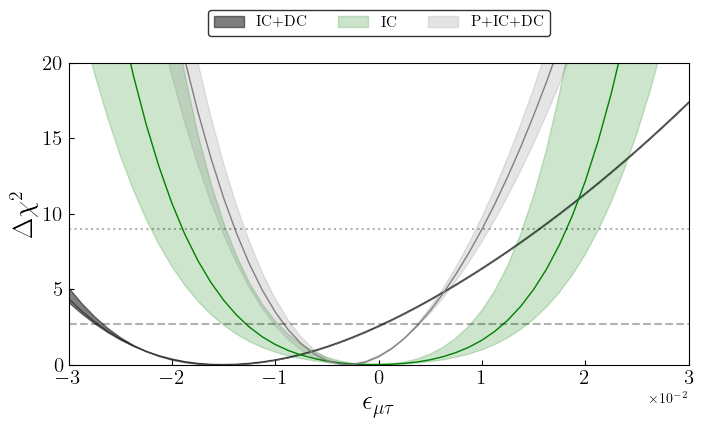

In [67]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
finer_e_range = np.linspace(-emt,emt,49)
alpha_regions = 0.2
alpha_lines = 1
lw=1

nsi_param = 'emt'
ax.fill_between(finer_e_range, best_cases[f'ID_{nsi_param}'], worst_cases[f'ID_{nsi_param}'],label='IC+DC', alpha=alpha_regions+0.3, color='k')
ax.plot(finer_e_range, normal_cases[f'ID_{nsi_param}'], alpha=alpha_lines-0.5, lw=lw,color='k')

ax.fill_between(finer_e_range, best_cases[f'I_{nsi_param}'], worst_cases[f'I_{nsi_param}'],label='IC', alpha=alpha_regions, color='g')
ax.plot(finer_e_range, normal_cases[f'I_{nsi_param}'], alpha=alpha_lines, lw=lw, color='g')

ax.fill_between(finer_e_range, best_cases[f'PID_{nsi_param}'], worst_cases[f'PID_{nsi_param}'], label='P+IC+DC', alpha=alpha_regions,color='grey')
ax.plot(finer_e_range, normal_cases['PID_emt'], alpha=alpha_lines, lw=lw,color='grey')



ax.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
ax.axhline(chi2.ppf(0.9973,1), alpha=0.3, c='black', ls = ':')

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=-3e-2, right=3e-2)
ax.set_xlabel(r'$\epsilon_{\mu\tau}$', fontsize=20)
ax.set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax.tick_params(labelsize=15)
handles, labels = ax.get_legend_handles_labels()
leg= ax.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.2),fontsize=11)
leg.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', direction='in', which='both')
ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.subplots_adjust(hspace=0.6)
#fig.savefig('article/figures/PID_3D_emt.pdf', bbox_inches="tight")
#from subprocess import call 
#_ = call('pdfcrop article/figures/PID_3D_emt.pdf article/figures/PID_3D_emt.pdf')

<ipython-input-66-265b94e256e3>:37: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.5)


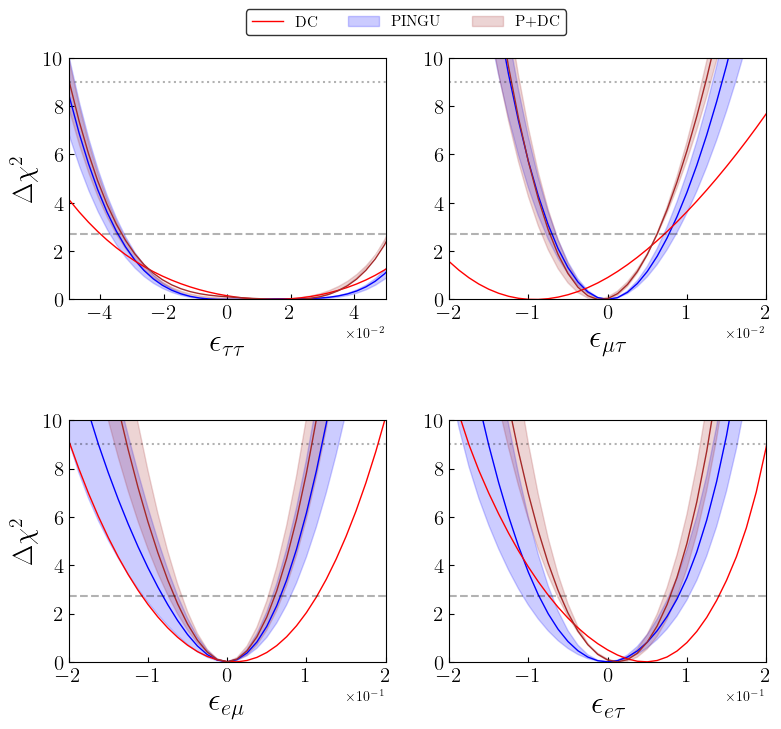

In [66]:
nsi_param_range = [np.linspace(-ett,ett,9),np.linspace(-emt,emt,9), np.linspace(-eem,eem,9), np.linspace(-eet,eet,9)]

fig, ax = plt.subplots(2,2,figsize=(9,8), constrained_layout=True)
ax = ax.flatten()
demidov_ett = (-0.055, 0.056)
demidov_emt = (-0.023, 0.016)
demidov_eem = (-0.21, 0.20)
demidov_eet = (-0.19, 0.20)
xlabels = [r'$\epsilon_{\tau\tau}$', r'$\epsilon_{\mu\tau}$', r'$\epsilon_{e\mu}$', r'$\epsilon_{e\tau}$']
demidovs =[demidov_ett, demidov_emt, demidov_eem, demidov_eet]
alpha_regions = 0.2
alpha_lines = 1
lw=1
xy_limits = [(5e-2,10), (2e-2,10), (2e-1,10), (2e-1,10)]
for i in range(4):
    finer_e_range = np.linspace(nsi_param_range[i].min(),nsi_param_range[i].max(),49)

    ax[i].fill_between(finer_e_range, worst_cases[f'P_{nsi_list[i]}'], best_cases[f'P_{nsi_list[i]}'], label='PINGU', alpha=alpha_regions, color='b')
    ax[i].plot(finer_e_range, normal_cases[f'P_{nsi_list[i]}'], alpha=alpha_lines, color='b', lw=lw)
    ax[i].plot(finer_e_range, normal_cases[f'D_{nsi_list[i]}'], label='DC', alpha=alpha_lines, color='r', lw=lw)
    ax[i].fill_between(finer_e_range, worst_cases[f'PD_{nsi_list[i]}'], best_cases[f'PD_{nsi_list[i]}'], label='P+DC', alpha=alpha_regions, color='brown')
    ax[i].plot(finer_e_range, normal_cases[f'PD_{nsi_list[i]}'], alpha=1, color='brown',lw=lw)

    ax[i].axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
    ax[i].axhline(chi2.ppf(0.9973,1), alpha=0.3, c='black', ls = ':')
    ax[i].set_ylim(bottom=0,top=xy_limits[i][1])
    ax[i].set_xlim((-xy_limits[i][0],xy_limits[i][0]))
    ax[i].set_xlabel(xlabels[i], fontsize=23)
    ax[i].tick_params(labelsize=15,axis='both', direction='in', which='both')
    ax[i].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

ax[0].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
ax[2].set_ylabel(r'$\Delta \chi^2$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
leg= fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95),fontsize=11)
leg.get_frame().set_edgecolor('k')
plt.subplots_adjust(hspace=0.5)
#plt.savefig('./article/figures/joint_3D_NO.pdf', bbox_inches="tight")
#save(fig, 'joint_3D_NO') #Doesnt work, legend removed
#savethesis(fig, 'joint_3D_NO')#Doesnt work, legend removed

In [23]:
index_list = ['$\epsilon_{\tau\tau}$', '$\epsilon_{\mu\tau}$', '$\epsilon_{e\mu}$', '$\epsilon_{e\tau}$']
colnames = ['Best 90', 'Best 3s', 'Normal 90', 'Normal 3s', 'Worst 90', 'Worst 3s']
df_I = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_D = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_ID = pd.DataFrame(columns=colnames,index=index_list, dtype=object)

df_P = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_PD = pd.DataFrame(columns=colnames,index=index_list, dtype=object)
df_PID = pd.DataFrame(columns=colnames,index=index_list, dtype=object)

name_list = ['D', 'P', 'PD']
IC_name_list = ['I', 'ID', 'PID']
nsi_param_range = [np.linspace(-ett,ett,49),np.linspace(-emt,emt,49), np.linspace(-eem,eem,49), np.linspace(-eet,eet,49)]

for i,epsilon in enumerate(nsi_list):
    for j, df in enumerate([df_D, df_P, df_PD]):
        df.loc[index_list[i],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'{name_list[j]}_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df.loc[index_list[i],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[i], best_cases[f'{name_list[j]}_{epsilon}'] - chi2.ppf(0.9973,1))),3)

        df.loc[index_list[i],f'Normal 90'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'{name_list[j]}_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df.loc[index_list[i],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[i], normal_cases[f'{name_list[j]}_{epsilon}'] - chi2.ppf(0.9973,1))),3)

        df.loc[index_list[i],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'{name_list[j]}_{epsilon}'] - chi2.ppf(0.9,1))),3)
        df.loc[index_list[i],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[i], worst_cases[f'{name_list[j]}_{epsilon}'] - chi2.ppf(0.9973,1))),3)

for i, df in enumerate([df_I, df_ID, df_PID]): 
    df.loc[index_list[1],f'Best 90'] = np.round(sproot(splrep(nsi_param_range[1], best_cases[f'{IC_name_list[i]}_emt'] - chi2.ppf(0.9,1))),3)
    df.loc[index_list[1],f'Best 3s'] = np.round(sproot(splrep(nsi_param_range[1], best_cases[f'{IC_name_list[i]}_emt'] - chi2.ppf(0.9973,1))),3)

    df.loc[index_list[1],f'Normal 90'] = np.round(sproot(splrep(nsi_param_range[1], normal_cases[f'{IC_name_list[i]}_emt'] - chi2.ppf(0.9,1))),3)
    df.loc[index_list[1],f'Normal 3s'] = np.round(sproot(splrep(nsi_param_range[1], normal_cases[f'{IC_name_list[i]}_emt'] - chi2.ppf(0.9973,1))),3)

    df.loc[index_list[1],f'Worst 90'] = np.round(sproot(splrep(nsi_param_range[1], worst_cases[f'{IC_name_list[i]}_emt'] - chi2.ppf(0.9,1))),3)
    df.loc[index_list[1],f'Worst 3s'] = np.round(sproot(splrep(nsi_param_range[1], worst_cases[f'{IC_name_list[i]}_emt'] - chi2.ppf(0.9973,1))),3)

In [25]:
ID_table = pd.concat([df_I, df_D,df_ID]).dropna()

PID_table = pd.concat([df_P, df_PD,df_PID]).dropna()

In [26]:
print(ID_table.to_latex(header=['Best 90\% CL','Best $3\sigma$','Normal 90\% CL','Normal $3\sigma$','Worst 90\% CL','Worst $3\sigma$'], index_names=True, column_format='lcccc',escape=False))

\begin{tabular}{lcccc}
\toprule
{} &     Best 90\% CL &   Best $3\sigma$ &   Normal 90\% CL & Normal $3\sigma$ &    Worst 90\% CL &  Worst $3\sigma$ \\
\midrule
$\epsilon_{\mu\tau}$  &   [-0.01, 0.009] &  [-0.015, 0.014] &  [-0.013, 0.012] &  [-0.019, 0.018] &  [-0.015, 0.014] &  [-0.022, 0.021] \\
$\epsilon_{\tau\tau}$ &   [-0.04, 0.063] &               [] &   [-0.04, 0.063] &               [] &   [-0.04, 0.063] &               [] \\
$\epsilon_{\mu\tau}$  &  [-0.023, 0.007] &          [0.023] &  [-0.023, 0.007] &          [0.023] &  [-0.023, 0.007] &          [0.023] \\
$\epsilon_{e\mu}$     &  [-0.107, 0.113] &   [-0.198, 0.19] &  [-0.107, 0.113] &   [-0.198, 0.19] &  [-0.107, 0.113] &   [-0.198, 0.19] \\
$\epsilon_{e\tau}$    &  [-0.111, 0.212] &     [-0.26, 0.3] &  [-0.111, 0.212] &     [-0.26, 0.3] &  [-0.111, 0.212] &     [-0.26, 0.3] \\
$\epsilon_{\mu\tau}$  &    [-0.027, 0.0] &          [0.016] &    [-0.027, 0.0] &          [0.016] &    [-0.027, 0.0] &          [0.016] \\
\bott

In [27]:
print(PID_table.to_latex(header=['Best 90\% CL','Best $3\sigma$','Normal 90\% CL','Normal $3\sigma$','Worst 90\% CL','Worst $3\sigma$'], index_names=True, column_format='lcccc',escape=False))

\begin{tabular}{lcccc}
\toprule
{} &     Best 90\% CL &   Best $3\sigma$ &   Normal 90\% CL & Normal $3\sigma$ &    Worst 90\% CL &  Worst $3\sigma$ \\
\midrule
$\epsilon_{\tau\tau}$ &  [-0.033, 0.057] &         [-0.048] &  [-0.034, 0.059] &         [-0.051] &  [-0.037, 0.062] &         [-0.055] \\
$\epsilon_{\mu\tau}$  &  [-0.007, 0.007] &  [-0.011, 0.013] &  [-0.007, 0.008] &  [-0.012, 0.014] &  [-0.008, 0.009] &  [-0.014, 0.016] \\
$\epsilon_{e\mu}$     &  [-0.062, 0.057] &  [-0.122, 0.104] &  [-0.081, 0.067] &   [-0.162, 0.12] &   [-0.106, 0.08] &  [-0.199, 0.141] \\
$\epsilon_{e\tau}$    &   [-0.07, 0.077] &   [-0.12, 0.133] &  [-0.086, 0.089] &   [-0.15, 0.148] &  [-0.107, 0.102] &  [-0.182, 0.164] \\
$\epsilon_{\tau\tau}$ &   [-0.033, 0.05] &  [-0.048, 0.065] &  [-0.033, 0.052] &   [-0.05, 0.067] &  [-0.035, 0.051] &  [-0.052, 0.068] \\
$\epsilon_{\mu\tau}$  &  [-0.007, 0.006] &  [-0.011, 0.012] &  [-0.007, 0.006] &  [-0.012, 0.012] &  [-0.004, 0.011] &   [-0.01, 0.017] \\
$\eps